# fetch data

In [ ]:
import requests
import csv
from datetime import datetime, timedelta

api_url = "https://neptune.kyogojo.com/api/statistics/get-multiple?stations=BSLG-002&days=1741651200000,1741737600000,1741824000000,1741910400000,1741996800000,1742083200000,1742169600000,1742256000000,1742342400000"

response = requests.get(api_url)
data = response.json() 

pressure_data = data["payload"]["data"][0]["pressure"]

csv_filename = r"C:\Users\Sarah\Desktop\trend_analysis\data\pressure_data.csv"

# save to CSV
with open(csv_filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Value", "Time (PST, UTC+8)"])

    for entry in pressure_data:
        value = entry["value"]
        timestamp = entry["time"]
        
        # convert UTC time to Philippine Standard Time (UTC+8)
        utc_time = datetime.utcfromtimestamp(timestamp / 1000)  #milliseconds to seconds
        pst_time = utc_time + timedelta(hours=8)  

        formatted_time = pst_time.strftime("%Y-%m-%d %H:%M:%S")    
        writer.writerow([value, formatted_time])

print(f"Data saved to {csv_filename}")


Data saved to C:\Users\Sarah\Desktop\trend_analysis\data\pressure_data.csv


C:\Users\Sarah\AppData\Local\Temp\ipykernel_3428\2815856751.py:30: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  utc_time = datetime.utcfromtimestamp(timestamp / 1000)  # Convert from milliseconds to seconds


#  data

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

# data
file_path = r"C:\Users\Sarah\Desktop\trend_analysis\data\water_pressure.csv"
df = pd.read_csv(file_path)

# column to datetime
df['time'] = pd.to_datetime(df['time'])

# extract time features
df['year'] = df['time'].dt.year
df['month'] = df['time'].dt.month
df['day'] = df['time'].dt.day
df['hour'] = df['time'].dt.hour
df['minute'] = df['time'].dt.minute
df['second'] = df['time'].dt.second
df['millisecond'] = df['time'].dt.microsecond // 1000  # microseconds to milliseconds

# drop time column
df.drop(columns=['time'], inplace=True)

# Features (X), target variable (y)
X = df.drop(columns=['value'])
y = df['value']

df.head()


,value,year,month,day,hour,minute,second,millisecond
0,43.09,2025,1,1,0,0,21,0
1,43.63,2025,1,1,0,1,21,0
2,44.20,2025,1,1,0,2,21,0
3,44.43,2025,1,1,0,3,21,0
4,42.67,2025,1,1,0,4,21,0


In [32]:
# 85% train, 15% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


In [38]:
# standardize features (x)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
import joblib

# Save the scaler
joblib.dump(scaler, r"C:\Users\Sarah\Desktop\trend_analysis\model\scaler.pkl")
print("Scaler saved successfully!")


Scaler saved successfully!


In [39]:
# Wrap the scaled arrays with the original feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [40]:

# train
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

print(model)


RandomForestRegressor(random_state=42)


In [41]:
# R-squared score
train_score = model.score(X_train_scaled, y_train)
test_score = model.score(X_test_scaled, y_test)

# Cross-validation
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)

print(f"Train R-squared: {train_score:.4f}")
print(f"Test R-squared: {test_score:.4f}")
print(f"Cross-validation score: {cv_scores.mean():.4f}")


Train R-squared: 0.9994
Test R-squared: 0.9956
Cross-validation score: 0.9942


In [42]:
# Predict on test set
y_pred = model.predict(X_test_scaled)

# Show some predictions
df_predictions = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred})
print(df_predictions.head(10))


   Actual  Predicted
0   31.30    31.4216
1   54.68    54.5640
2   41.30    42.4477
3   43.46    43.6453
4   45.07    44.5661
5   29.19    29.2249
6   50.68    51.0055
7   40.04    40.2289
8   38.64    38.6433
9   51.35    50.8536


C:\Users\Sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


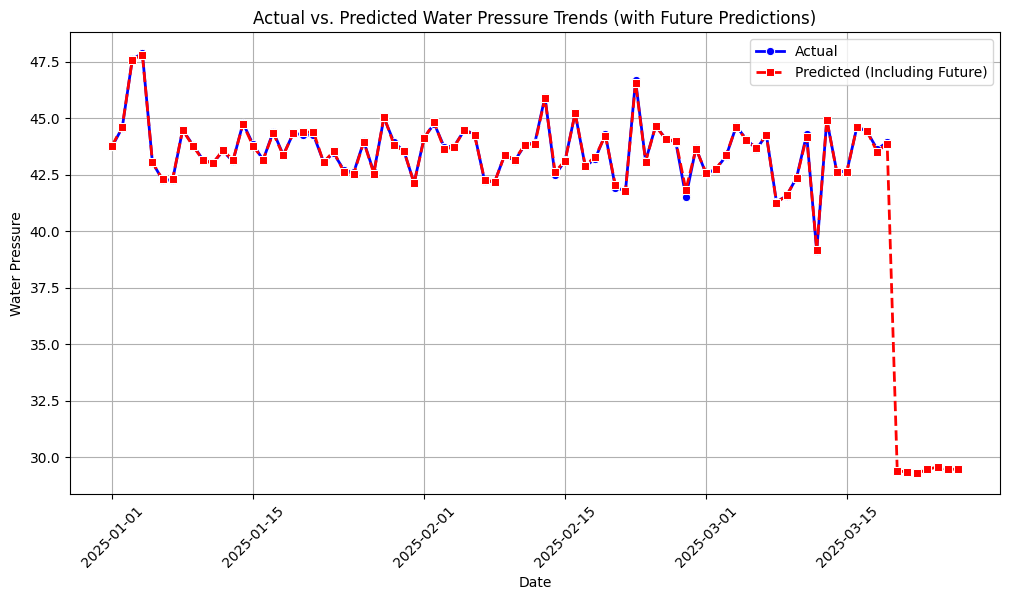

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta

# Convert X_test back to DataFrame with column names
X_test_df = pd.DataFrame(X_test, columns=['year', 'month', 'day', 'hour', 'minute', 'second', 'millisecond'])
X_test_df['Actual'] = y_test.values
X_test_df['Predicted'] = y_pred

# Group by day (calculate average actual and predicted value per day)
daily_avg = X_test_df.groupby(['year', 'month', 'day'])[['Actual', 'Predicted']].mean().reset_index()

# Create date column for plotting
daily_avg['date'] = pd.to_datetime(daily_avg[['year', 'month', 'day']])

### 📌 Generate Future Dates for Prediction
future_days = 7  # Predict next 7 days
last_date = daily_avg['date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, future_days + 1)]

# Create future DataFrame
future_df = pd.DataFrame({
    'year': [d.year for d in future_dates],
    'month': [d.month for d in future_dates],
    'day': [d.day for d in future_dates],
    'hour': [0] * future_days,  # Assuming midnight for simplicity
    'minute': [0] * future_days,
    'second': [0] * future_days,
    'millisecond': [0] * future_days
})

# Standardize future data
future_scaled = scaler.transform(future_df)

# Predict future water pressure
future_df['Predicted'] = model.predict(future_scaled)
future_df['date'] = future_dates  # Assign future date column

# Append future predictions to daily_avg
extended_df = pd.concat([daily_avg, future_df], ignore_index=True)

### 📌 Plot Actual vs. Predicted (with Future Predictions)
plt.figure(figsize=(12, 6))
sns.lineplot(data=extended_df, x='date', y='Actual', label='Actual', marker='o', linewidth=2, color='blue')
sns.lineplot(data=extended_df, x='date', y='Predicted', label='Predicted (Including Future)', marker='s', linewidth=2, linestyle='dashed', color='red')

# Format the plot
plt.xlabel("Date")
plt.ylabel("Water Pressure")
plt.title("Actual vs. Predicted Water Pressure Trends (with Future Predictions)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [44]:
import joblib

# Save the trained model
joblib.dump(model, r"C:\Users\Sarah\Desktop\trend_analysis\model\random_forest_model.pkl")

print("Model saved successfully!")


Model saved successfully!


In [45]:
# Load the model
loaded_model = joblib.load(r"C:\Users\Sarah\Desktop\trend_analysis\model\random_forest_model.pkl")

print("Model loaded successfully!")

# Now you can make predictions using the loaded model
y_pred = loaded_model.predict(X_test)


Model loaded successfully!


C:\Users\Sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
